# Laboratory work  3
**Классификация в sklearn. Метрики классификации**

Completed: гр.№ 6131-010402D, Griaznov Ilia

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import plotly.express as px
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, f1_score,classification_report, confusion_matrix

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

**1. Многоклассовая классификация:**

1.1 На любом датасете продемонстрировать многоклассовую классификацию с помощью ЛЮБОГО алгоритма. Оценить accuracy.

1.2. То же самое с использованием кросс-валидации

1.3. Поиграться с гиперпараметром, связанным со сложностью модели (в случае kNN — k_neighbours) и построить график accuracy для train set и test_set для разных значений гиперпараметра (в лекции есть пример построения подобного графика для kNN и датасета cancer, но можно строить как угодно такой график)

1.4. Построить confusion matrix (это вроде матрицы TN / TP/ FN/ FP, только расширенной для многоклассовой классификации, чтобы понять в какие стороны чаще ошибается классификатор). ([пример](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)):

####  Описание данных `Mobile Price Classification`

**Исходные данные:** https://www.kaggle.com/iabhishekofficial/mobile-price-classification?select=test.csv <br><br>
**Набор данных: "Классификация мобильных телефонов по цене"**<br>
Context

Боб основал свою собственную мобильную компанию. Он хочет дать жесткий бой крупным компаниям, таким как Apple, Samsung и т. д.

Он не знает, как оценить стоимость мобильных телефонов, которые производит его компания. На этом конкурентном рынке мобильных телефонов вы не можете просто предполагать. Для решения этой проблемы он собирает данные о продажах мобильных телефонов различных компаний.

Боб хочет выяснить какую-то связь между характеристиками мобильного телефона (например: оперативная память, внутренняя память и т. д.) и его продажной ценой. Но он не так хорош в машинном обучении. Поэтому ему нужна ваша помощь, чтобы решить эту проблему.

В этой задаче вам не нужно предсказывать фактическую цену, а нужно предсказать диапазон цен, указывающий, насколько высока цена. 

In [2]:
data = pd.read_csv(r'train.csv')
print(data.head(10))
print('shape: ', data.shape)

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   
5           1859     0          0.5         1   3       0          22    0.7   
6           1821     0          1.7         0   4       1          10    0.8   
7           1954     0          0.5         1   0       0          24    0.8   
8           1445     1          0.5         0   0       0          53    0.7   
9            509     1          0.6         1   2       1           9    0.1   

   mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2   2         20    

**Классификация (Decision tree)**


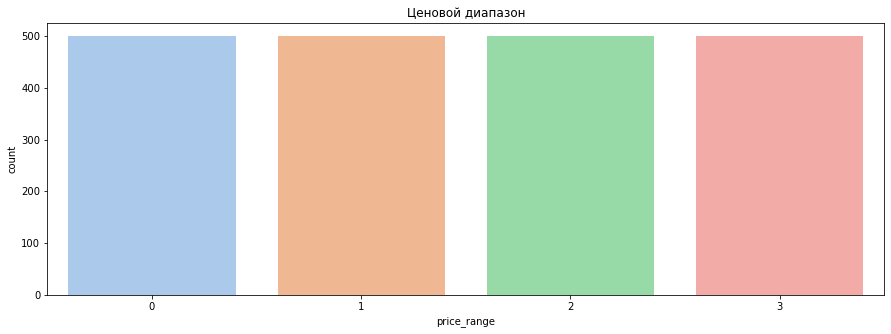

In [3]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(data['price_range'], palette='pastel')
ax.set(title='Ценовой диапазон')
plt.show()

Целевая переменная хорошо сбалансирована

#### Посмотрим корреляцию между признаками:

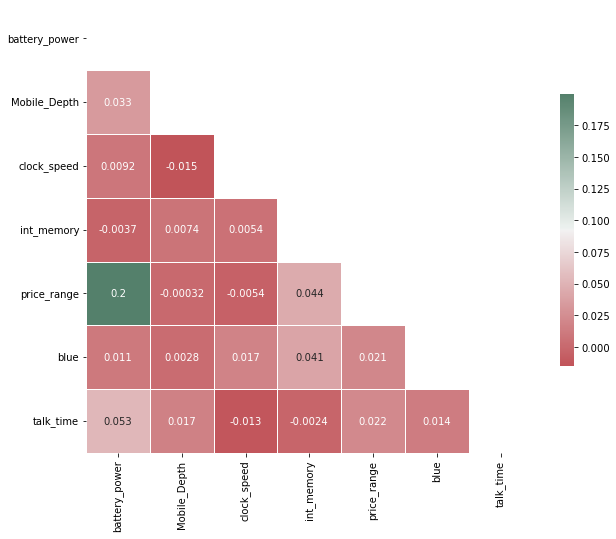

In [4]:
stars_features = {
    'battery_power': data['battery_power'],
    'Mobile_Depth': data['m_dep'],
    'clock_speed': data['clock_speed'],
    'int_memory': data['int_memory'],
    'price_range': data['price_range'],
    'blue': data['blue'],
    'talk_time': data['talk_time']
}

stars_features = pd.DataFrame.from_dict(stars_features)
stars_features['price_range'] = stars_features['price_range'].astype('category').cat.codes
stars_features['blue'] = stars_features['blue'].astype('category').cat.codes
stars_features['talk_time'] = stars_features['talk_time'].astype('category').cat.codes

corr = stars_features.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(10, 150, 50, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True)
plt.show()

Целевая переменная нормально коррелирует с признаками luminosuty, radius, absolute_magnitude

#### Параметры для дерева решений

In [5]:
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )

#### Поиск лучших гиперпараметров

In [6]:
def do_grid_search(model,params, x_train, y_train, x_test, refit='accuracy'):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    grid_search = GridSearchCV(model, params, scoring=['accuracy'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)

#### Вывод результата

In [7]:
def print_result(y_test, pred=None):
  print("результат классификации: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  cmap = sns.diverging_palette(220, 10, 50, as_cmap=True)
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)
  plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(stars_features.drop('price_range',axis=1), stars_features['price_range'], test_size=0.6, random_state=42)

**Без настройки гиперпараметров**

результат классификации: 
               precision    recall  f1-score   support

           0       0.25      0.25      0.25       305
           1       0.24      0.26      0.25       304
           2       0.26      0.24      0.25       300
           3       0.21      0.21      0.21       291

    accuracy                           0.24      1200
   macro avg       0.24      0.24      0.24      1200
weighted avg       0.24      0.24      0.24      1200

Матрица ошибок: 
 [[76 82 73 74]
 [83 78 66 77]
 [69 82 73 76]
 [78 81 71 61]] 



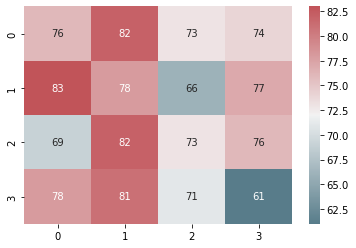

Средняя точность без настройки гиперпараметров:  0.27875000000000005


In [9]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print_result(y_test=y_test, pred=predictions)
score = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность без настройки гиперпараметров: ', np.mean(score))

### Настройка гиперпараметров

In [10]:
do_grid_search(model=dtree,  params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Best params for accuracy
{'max_depth': 1.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}


результат классификации: 
               precision    recall  f1-score   support

           0       0.29      0.40      0.34       305
           1       0.25      0.18      0.21       304
           2       0.27      0.09      0.14       300
           3       0.30      0.49      0.37       291

    accuracy                           0.29      1200
   macro avg       0.28      0.29      0.26      1200
weighted avg       0.28      0.29      0.26      1200

Матрица ошибок: 
 [[121  62  36  86]
 [105  54  17 128]
 [104  52  28 116]
 [ 83  44  21 143]] 



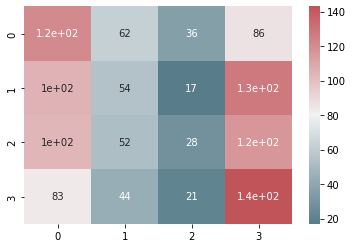

Средняя точность с настройкой гиперпараметров GridSearch:  0.24875000000000003


In [11]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=4.0, min_samples_leaf=0.01, min_samples_split=0.01)

print_result(y_test=y_test, pred=dtree_grid.fit(X_train, y_train).predict(X_test))
score = cross_val_score(dtree_grid, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров GridSearch: ', np.mean(score))

In [12]:
max_depth = np.linspace(1, 32, 32, endpoint=True)
accuracy_result = []
cv_result = []
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

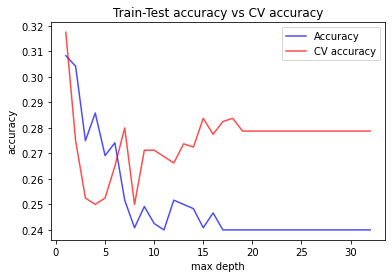

In [13]:
plt.plot(max_depth, accuracy_result, color='b', label='Accuracy', alpha=0.7)
plt.plot(max_depth, cv_result, color='r', label='CV accuracy', alpha=0.7)
plt.title('Train-Test accuracy vs CV accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

Рост точности происходит, к сожалению, не велик. Точность остановилась на 15

In [14]:
accuracy_result_train, accuracy_result_test = [],[]
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

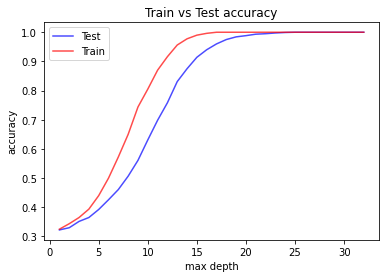

In [15]:
plt.plot(max_depth, accuracy_result_test, color='b', label='Test', alpha=0.7)
plt.plot(max_depth, accuracy_result_train, color='r', label='Train', alpha=0.7)
plt.title('Train vs Test accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

Настройка гиперпараметров поиском по сетке показывает себя с более лушчей стороны.
Максимальная точность на 15

### Масштабирование признаков

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       0.25      0.25      0.25       305
           1       0.25      0.26      0.26       304
           2       0.25      0.24      0.25       300
           3       0.21      0.21      0.21       291

    accuracy                           0.24      1200
   macro avg       0.24      0.24      0.24      1200
weighted avg       0.24      0.24      0.24      1200

Матрица ошибок: 
 [[77 79 75 74]
 [81 80 66 77]
 [71 80 72 77]
 [79 77 73 62]] 



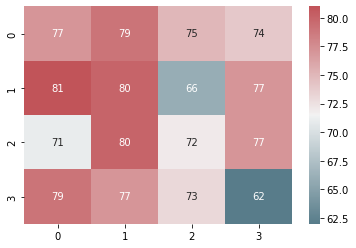

Средняя точность с масштабируемыми признаками:  0.27874999999999994


In [17]:
dtree_scaled = DecisionTreeClassifier(random_state=42)

print_result(y_test=y_test, pred=dtree_scaled.fit(X_train_scaled, y_train).predict(X_test_scaled))
score = cross_val_score(dtree_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')
print('Средняя точность с масштабируемыми признаками: ', np.mean(score))

**2. Бинарная классификация.**

На любом (но уже другом, бинарном) датасете продемонстрировать бинарную классификацию (можно использовать любой алгоритм), посчитать метрики: accuracy, precision, recall, f-measure, а также составить `classification_report`

## Описание данных

**Исходные данные:** https://www.kaggle.com/nareshbhat/wine-quality-binary-classification <br><br>
**Набор данных: классификация качества вина** <br>
Этот набор данных содержит информацию, касающуюся красного вина, различных факторов, влияющих на качество.

Входные переменные (на основе физико-химических тестов): 
-  фиксированная кислотность 
-  летучая кислотность 
-  лимонная кислота 
-  остаточный сахар 
-  хлориды 
-  свободный диоксид серы 
-  диоксид серы общий 
-  плотность 
-  pH 
-  сульфаты 
-  алкоголь 

Выходная переменная (на основе сенсорных данных): 
-  качество («хорошо» и «плохо» по баллам> 5 и <5)

In [18]:
wine_data = pd.read_csv('wine.csv')
wine_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,bad
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,bad
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,good
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,good
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,bad


-----------
## Классификация (Логистическая регрессия)
---------

In [19]:
wine_data = wine_data.replace(['good', 'bad'], [0,1])
target = wine_data.quality
features = wine_data.drop(['quality'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

### Без настройки гиперпараметров

результат классификации: 
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       267
           1       0.68      0.73      0.70       213

    accuracy                           0.73       480
   macro avg       0.72      0.73      0.72       480
weighted avg       0.73      0.72      0.73       480

Матрица ошибок: 
 [[193  74]
 [ 58 155]] 



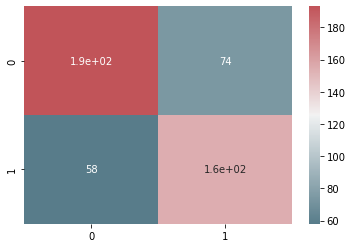

In [21]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train ,y_train)
lr_pred = lr.predict(X_test)

print_result(y_test=y_test, pred=lr_pred)

In [22]:
scores = cross_val_score(lr, X_train, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  0.7560898462524023


### С настройкой

In [23]:
penalties = ['l2', 'none']
accuracy_result = []
cv_result = []
for penalty in penalties:
  # для 'newton-cg' возможно испльзование только 'l2' или 'none' в качестве параметров
  model = LogisticRegression(random_state=42, solver='newton-cg', penalty=penalty)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

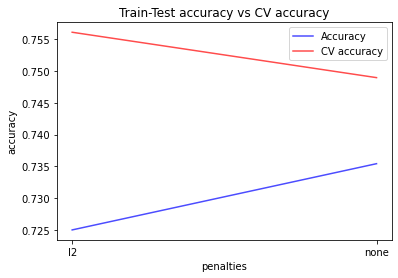

In [24]:
plt.plot(penalties, accuracy_result, color='b', label='Accuracy', alpha=0.7)
plt.plot(penalties, cv_result, color='r', label='CV accuracy', alpha=0.7)
plt.title('Train-Test accuracy vs CV accuracy')
plt.legend()
plt.xlabel('penalties'); plt.ylabel('accuracy')
plt.show()

Точность по оценке train-test без регуляризации (штрафа) даёт лучший результат, но если использовать в качестве оценки алгоритма кросс-валидацию, то с использованием L2-регуляризации точность алгоритма имеет максимальное значение.

In [25]:
accuracy_result_train, accuracy_result_test = [],[]
for penalty in penalties:
  model = LogisticRegression(random_state=42, solver='newton-cg', penalty=penalty)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

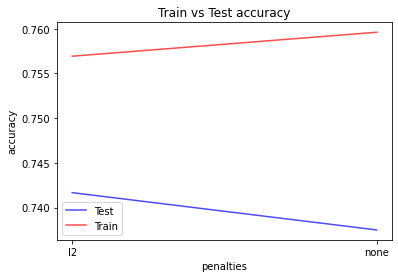

In [26]:
plt.plot(penalties, accuracy_result_test, color='b', label='Test', alpha=0.7)
plt.plot(penalties, accuracy_result_train, color='r', label='Train', alpha=0.7)
plt.title('Train vs Test accuracy')
plt.xlabel('penalties'); plt.ylabel('accuracy')
plt.legend()
plt.show()

### Масштабирование признаков

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       0.78      0.73      0.76       267
           1       0.69      0.74      0.71       213

    accuracy                           0.74       480
   macro avg       0.73      0.74      0.73       480
weighted avg       0.74      0.74      0.74       480

Матрица ошибок: 
 [[196  71]
 [ 56 157]] 



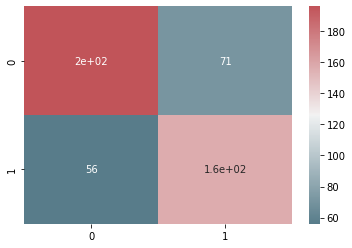

In [28]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train_scaled ,y_train)
lr_pred = lr.predict(X_test_scaled)

print_result(y_test=y_test, pred=lr_pred)

In [29]:
scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  0.7498478539397821


С использованием масштабирования признаков точность алгоритма уменьшилась.

### Настройка гиперпараметров

In [30]:
params={"C":[*np.arange(0,1,0.01)], "penalty":["none","l2"]}
do_grid_search(model=lr,  params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params for accuracy
{'C': 0.74, 'penalty': 'l2'}


результат классификации: 
               precision    recall  f1-score   support

           0       0.75      0.72      0.73       267
           1       0.66      0.69      0.68       213

    accuracy                           0.71       480
   macro avg       0.71      0.71      0.71       480
weighted avg       0.71      0.71      0.71       480

Матрица ошибок: 
 [[192  75]
 [ 65 148]] 



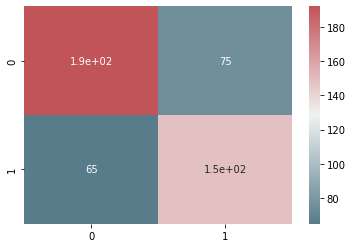

Средняя точность с настройкой гиперпараметров GridSearch:  0.760550128122998


In [31]:
lr = LogisticRegression(C=.34,penalty="l2")
lr.fit(X_train,y_train)

print_result(y_test=y_test, pred=lr.fit(X_train, y_train).predict(X_test))
score = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров GridSearch: ', np.mean(score))

С настройкой гиперпараметров точность алгоритма увеличались на ~0.002